<a href="https://colab.research.google.com/github/rliu7926/weinstein-ligo-research/blob/main/2.3%20SNR%20Spread%20Simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
## Install packages and initialize environment
! pip install -q 'lalsuite==6.66' 'PyCBC==1.15.3' 

%matplotlib inline
import numpy
import pylab
import pycbc
from pycbc.waveform import get_td_waveform
import pycbc.noise
import pycbc.psd
from random import randint
from pycbc.filter import matched_filter
from pycbc.psd import interpolate, inverse_spectrum_truncation

In [40]:
def create_waveform(mass1, mass2, resolution, frequencybound, distance):
  
  redshift = 1 + 72*distance/(299792.458-72*distance)
  
  waveform, waveform_cross = get_td_waveform(approximant="SEOBNRv4_opt",
                                             mass1=mass1,
                                             mass2=mass2,
                                             delta_t=resolution/redshift,
                                             f_lower=frequencybound)
  
  waveform_amplitude = [0.0] * len(waveform)
  waveform_time = [0.0] * len(waveform)

  for i in range(0, len(waveform)-1):
    waveform_amplitude[i] = waveform[i]
    waveform_time[i] = waveform.sample_times[i]

  waveform_amplitude = [i/distance for i in waveform_amplitude]
  waveform_time = [i*redshift for i in waveform_time]

  waveform_amplitude = numpy.array(waveform_amplitude)
  waveform_time = numpy.array(waveform_time)

  return waveform_amplitude, waveform_time
  

In [41]:
def determine_SNR(mass1, mass2, waveformmass1, waveformmass2, resolution, frequencybound, psdresolution, distance, noise, noisetime, graph = "F"):

  gwamp, gwtime = create_waveform(mass1, mass2, resolution, frequencybound, distance)

  # Generate the frequency series PSD

  samples = int(4096 / psdresolution) + 1

  designpsd = pycbc.psd.from_string(psd_name = noise,
                                         length = samples,
                                         delta_f = psdresolution, 
                                         low_freq_cutoff = frequencybound)

  # Generate [noisetime] seconds of Gaussian noise at [1/resolution] Hz

  timesamples = int(noisetime / resolution)
  gaussiannoise = pycbc.noise.gaussian.noise_from_psd(length = timesamples, 
                                                      delta_t = resolution,
                                                      psd = designpsd,
                                                      seed = None)
  
  # Resize GW signal to the length of the random noise sample

  timeshift = randint(0, len(gaussiannoise)-len(gwamp)) # Add a random timeshift
  gwamp = numpy.append([0] * timeshift, gwamp) # Append zeroes before the wave
  gwamp = numpy.append(gwamp, [0] * (len(gaussiannoise)-len(gwamp))) # Append zeroes after the wave 
  gwtime = gaussiannoise.sample_times

  ## Add the waveform to the generated noise

  gwnoise = gaussiannoise + gwamp

  ## Calculate the SNR time series 

  waveform_template, waveform_template_cross = get_td_waveform(approximant="SEOBNRv4_opt",
                                                               mass1=waveformmass1,
                                                               mass2=waveformmass2,
                                                               delta_t=resolution, 
                                                               f_lower=frequencybound)

  waveform_template.resize(len(gaussiannoise))
  waveform_template = waveform_template.cyclic_time_shift(waveform_template.start_time)

  ## Calculate and plot the SNR
  
  psd = gwnoise.psd(4)
  psd = interpolate(psd, gwnoise.delta_f)
  psd = inverse_spectrum_truncation(psd, 4*gwnoise.sample_rate, low_frequency_cutoff=frequencybound)

  gwsnr = matched_filter(template=waveform_template,
                         data=gwnoise,
                         psd = psd,
                         low_frequency_cutoff=frequencybound)
  
  if graph == "T":
    pylab.figure()
    pylab.plot(gwsnr.sample_times, abs(gwsnr))

  gwsnrpeak = abs(gwsnr).numpy().argmax()
  gwsnrpeakvalue = gwsnr[gwsnrpeak]
  gwsnrpeaktime = gwsnr.sample_times[gwsnrpeak]

  print("A signal was found at {} s with SNR {}.".format(gwsnrpeaktime, abs(gwsnrpeakvalue)))
  print("The redshifted waveform was inserted at time {} s.".format(timeshift*resolution))

  return(abs(gwsnrpeakvalue))


In [ ]:
## Doesn't work for masses under 20 SM

distances = numpy.arange(50, 2050, 50)

snr20 = [0] * 40
snr30 = [0] * 40
snr40 = [0] * 40
snr50 = [0] * 40
snr60 = [0] * 40
snr70 = [0] * 40
snr80 = [0] * 40
snr90 = [0] * 40
snr100 = [0] * 40

snrlist = [snr20, snr30, snr40, snr50, snr60, snr70, snr80, snr90, snr100]
massarray = [20, 30, 40, 50, 60, 70, 80, 90, 100]

massindex = 0

for snr in snrlist:
  distanceindex = 0

  for distance in distances: 
    snrlist[massindex][distanceindex] = determine_SNR(mass1=massarray[massindex], mass2=massarray[massindex], 
                                               waveformmass1=massarray[massindex], waveformmass2=massarray[massindex],
                                               resolution=1.0/1024, frequencybound=20, psdresolution=1.0/16,
                                               distance=distance, noise='aLIGODesignSensitivityP1200087', noisetime=32)
    
    distanceindex = distanceindex + 1

  massindex = massindex + 1

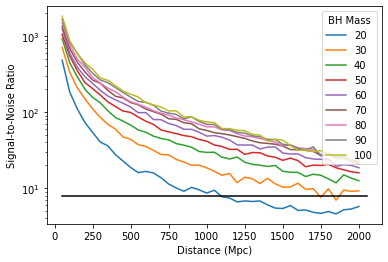

In [ ]:
index = 0

for snr in snrlist: 
  pylab.plot(distances, snrlist[index])
  index = index + 1

pylab.yscale('log')
x = [50, 2050]
y = [8, 8]
pylab.plot(x, y, color='black')
pylab.legend(labels=[20, 30, 40, 50, 60, 70, 80, 90, 100], title="BH Mass")
pylab.xlabel("Distance (Mpc)")
pylab.ylabel("Signal-to-Noise Ratio")

In [ ]:
## Look at the impact of imprecise waveforms for m = 30, 40, 50

masses30 = numpy.arange(25, 35, 0.25)
masses40 = numpy.arange(35, 45, 0.25)
masses50 = numpy.arange(45, 55, 0.25)

snr30d500 = [0] * 40
snr40d500 = [0] * 40
snr50d500 = [0] * 40

for index in range((len(masses30))):
  snr30d500[index] = determine_SNR(mass1=30, mass2=30,
                                      waveformmass1=masses30[index], waveformmass2=masses30[index],
                                      resolution=1.0/1024, frequencybound=20, psdresolution=1.0/16,
                                      distance=50, noise='aLIGODesignSensitivityP1200087', noisetime=32)
  
for index in range((len(masses40))):
  snr40d500[index] = determine_SNR(mass1=40, mass2=40,
                                      waveformmass1=masses40[index], waveformmass2=masses40[index],
                                      resolution=1.0/1024, frequencybound=20, psdresolution=1.0/16,
                                      distance=50, noise='aLIGODesignSensitivityP1200087', noisetime=32)
  
for index in range((len(masses50))):
  snr50d500[index] = determine_SNR(mass1=50, mass2=50,
                                      waveformmass1=masses50[index], waveformmass2=masses50[index],
                                      resolution=1.0/1024, frequencybound=20, psdresolution=1.0/16,
                                      distance=50, noise='aLIGODesignSensitivityP1200087', noisetime=32)

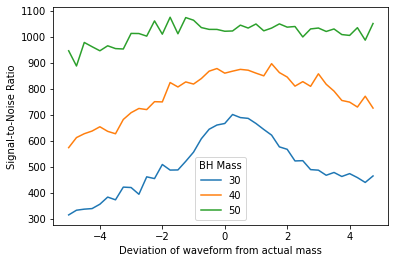

In [ ]:
masses = numpy.arange(-5, 5, 0.25)

pylab.plot(masses, snr30d500)
pylab.plot(masses, snr40d500)
pylab.plot(masses, snr50d500)
pylab.xlabel("Deviation of waveform from actual mass")
pylab.ylabel("Signal-to-Noise Ratio")
pylab.legend(labels=[30, 40, 50], title="BH Mass")


In [ ]:
snr30 = numpy.zeros( (20, 20) )

for row in range(len(snr30)):
  for column in range(len(snr30[row])):

    mass1 = 25 + 0.5*row
    mass2 = 25 + 0.5*column

    snr30[row][column] = determine_SNR(mass1=mass1, mass2=mass2,
                                      waveformmass1=30, waveformmass2=30,
                                      resolution=1.0/1024, frequencybound=20, psdresolution=1.0/16,
                                      distance=500, noise='aLIGODesignSensitivityP1200087', noisetime=32)

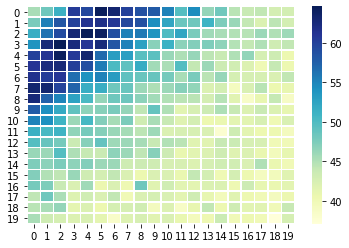

In [ ]:
import seaborn as sns

sns.heatmap(snr30, linewidths=0.5, cmap="YlGnBu")


In [ ]:
## Different noise curves

distances = numpy.arange(100, 2100, 100)

snr30design = [0] * 20
snr30low = [0] * 20
snr30high = [0] * 20

for index in range((len(snr30design))):
  snr30design[index] = determine_SNR(mass1=30, mass2=30,
                                      waveformmass1=30, waveformmass2=30,
                                      resolution=1.0/1024, frequencybound=20, psdresolution=1.0/16,
                                      distance=distances[index], noise='aLIGODesignSensitivityP1200087', noisetime=32)
  
for index in range((len(snr30low))):
  snr30low[index] = determine_SNR(mass1=30, mass2=30,
                                      waveformmass1=30, waveformmass2=30,
                                      resolution=1.0/1024, frequencybound=20, psdresolution=1.0/16,
                                      distance=distances[index], noise='aLIGOEarlyLowSensitivityP1200087', noisetime=32)
  
for index in range((len(snr30high))):
  snr30high[index] = determine_SNR(mass1=30, mass2=30,
                                      waveformmass1=30, waveformmass2=30,
                                      resolution=1.0/1024, frequencybound=20, psdresolution=1.0/16,
                                      distance=distances[index], noise='aLIGOEarlyHighSensitivityP1200087', noisetime=32)


Text(0, 0.5, 'Signal-to-Noise Ratio')

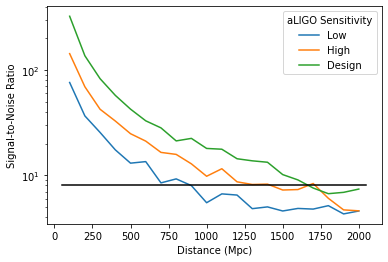

In [ ]:
pylab.plot(distances, snr30low)
pylab.plot(distances, snr30high)
pylab.plot(distances, snr30design)

pylab.yscale('log')
x = [50, 2050]
y = [8, 8]
pylab.plot(x, y, color='black')
pylab.legend(labels=['Low', 'High', 'Design'], title="aLIGO Sensitivity")
pylab.xlabel("Distance (Mpc)")
pylab.ylabel("Signal-to-Noise Ratio")



In [ ]:
snr40d500 = numpy.zeros( (40, 40) )

for row in range(len(snr40d500)):
  for column in range(len(snr40d500[row])):

    mass1 = 35 + 0.25*row
    mass2 = 35 + 0.25*column

    snr40d500[row][column] = determine_SNR(mass1=mass1, mass2=mass2,
                                      waveformmass1=40, waveformmass2=40,
                                      resolution=1.0/1024, frequencybound=20, psdresolution=1.0/16,
                                      distance=500, noise='aLIGODesignSensitivityP1200087', noisetime=32)

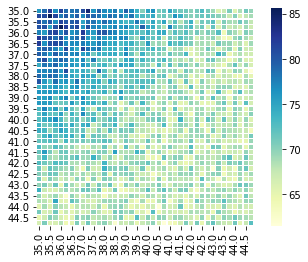

In [56]:
import seaborn as sns
import pandas as pd

names = numpy.arange(35, 45, 0.25)
snr40d500 = pd.DataFrame(snr40d500, columns=names, index=names)

sns.heatmap(snr40d500, linewidths=0.2, cmap="YlGnBu", square="True")


In [ ]:
snr30test = [0] * 500
snr40test = [0] * 500
snr50test = [0] * 500

for index in range(500):
  snr30test[index] = determine_SNR(mass1=30, mass2=30,
                                   waveformmass1=30, waveformmass2=30,
                                   resolution=1.0/1024, frequencybound=20, psdresolution=1.0/16,
                                   distance=500, noise='aLIGODesignSensitivityP1200087', noisetime=32)
  
  snr40test[index] = determine_SNR(mass1=40, mass2=40,
                                   waveformmass1=40, waveformmass2=40,
                                   resolution=1.0/1024, frequencybound=20, psdresolution=1.0/16,
                                   distance=500, noise='aLIGODesignSensitivityP1200087', noisetime=32)
  
  snr50test[index] = determine_SNR(mass1=50, mass2=50,
                                   waveformmass1=50, waveformmass2=50,
                                   resolution=1.0/1024, frequencybound=20, psdresolution=1.0/16,
                                   distance=500, noise='aLIGODesignSensitivityP1200087', noisetime=32)
  
  print(index)

The average SNR for m=30, d=500 is 44.17599373892851 and the standard deviation is 1.608421026770784 with a skewness of 0.07557095567950556.
The average SNR for m=40, d=500 is 68.48876759348883 and the standard deviation is 2.1145601891074444 with a skewness of 0.004834258084507885.
The average SNR for m=50, d=500 is 92.87204818200728 and the standard deviation is 2.8053772564203183 with a skewness of 0.01637309649692844.


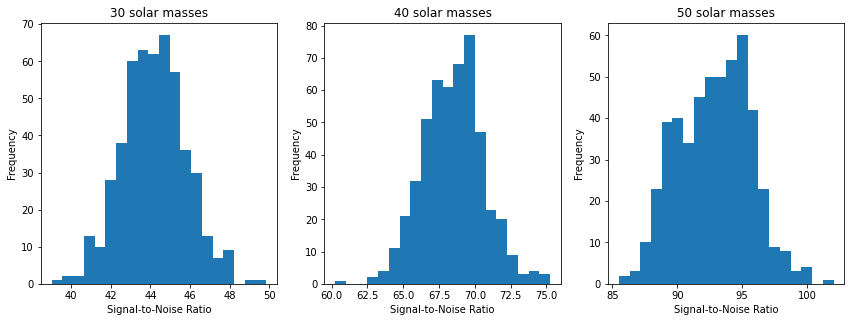

In [53]:
import matplotlib.pyplot as plt
from scipy.stats import skew

fig = plt.figure()

plt.subplot(1,3,1)
plt.hist(snr30test, bins=20)
plt.ylabel("Frequency")
plt.xlabel("Signal-to-Noise Ratio")
plt.title("30 solar masses")

plt.subplot(1,3,2)
plt.hist(snr40test, bins=20)
plt.ylabel("Frequency")
plt.xlabel("Signal-to-Noise Ratio")
plt.title("40 solar masses")

plt.subplot(1,3,3)
plt.hist(snr50test, bins=20)
plt.ylabel("Frequency")
plt.xlabel("Signal-to-Noise Ratio")
plt.title("50 solar masses")

fig.set_figheight(4.8)
fig.set_figwidth(14.4)

fig.show()

print("The average SNR for m=30, d=500 is {} and the standard deviation is {} with a skewness of {}.".format(numpy.mean(snr30test), numpy.std(snr30test), skew(snr30test)))
print("The average SNR for m=40, d=500 is {} and the standard deviation is {} with a skewness of {}.".format(numpy.mean(snr40test), numpy.std(snr40test), skew(snr40test)))
print("The average SNR for m=50, d=500 is {} and the standard deviation is {} with a skewness of {}.".format(numpy.mean(snr50test), numpy.std(snr50test), skew(snr50test)))

In [ ]:
## Determine SNR of pure noise (design sensitivity)

designpsd = pycbc.psd.from_string(psd_name = 'aLIGODesignSensitivityP1200087',
                                  length = int(4096 * 16) + 1, 
                                  delta_f = 1.0/16, 
                                  low_freq_cutoff = 10)

import random 

designnoisesnr = [0] * 1000

waveform_template, waveform_template_cross = get_td_waveform(approximant="SEOBNRv4_opt",
                                                             mass1=30, mass2=30, delta_t=1.0/4096, f_lower=10)
waveform_template.resize(32*4096)
waveform_template = waveform_template.cyclic_time_shift(waveform_template.start_time)


for index in range(1000):

  seed = random.randint(0, 100000)
  designnoise = pycbc.noise.noise_from_psd(length = 32*4096,
                                           delta_t = 1.0/4096,
                                           psd = designpsd,
                                           seed = seed)
  
  psd = designnoise.psd(4)
  psd = interpolate(psd, designnoise.delta_f)
  psd = inverse_spectrum_truncation(psd, 4*designnoise.sample_rate, low_frequency_cutoff=10)

  snr = matched_filter(template=waveform_template, data=designnoise, psd=psd, low_frequency_cutoff=10)

  snrpeak = abs(snr).numpy().argmax()
  snrpeakvalue = snr[snrpeak]

  designnoisesnr[index] = abs(snrpeakvalue)
  print(index, designnoisesnr[index])


## Determine SNR of pure noise (low sensitivity)

designpsd = pycbc.psd.from_string(psd_name = 'aLIGOEarlyLowSensitivityP1200087',
                                  length = int(4096 * 16) + 1, 
                                  delta_f = 1.0/16, 
                                  low_freq_cutoff = 10)

import random 

noisesnr = [0] * 1000

waveform_template, waveform_template_cross = get_td_waveform(approximant="SEOBNRv4_opt",
                                                             mass1=30, mass2=30, delta_t=1.0/4096, f_lower=10)
waveform_template.resize(32*4096)
waveform_template = waveform_template.cyclic_time_shift(waveform_template.start_time)


for index in range(1000):

  seed = random.randint(0, 100000)
  designnoise = pycbc.noise.noise_from_psd(length = 32*4096,
                                           delta_t = 1.0/4096,
                                           psd = designpsd,
                                           seed = seed)
  
  psd = designnoise.psd(4)
  psd = interpolate(psd, designnoise.delta_f)
  psd = inverse_spectrum_truncation(psd, 4*designnoise.sample_rate, low_frequency_cutoff=10)

  snr = matched_filter(template=waveform_template, data=designnoise, psd=psd, low_frequency_cutoff=10)

  snrpeak = abs(snr).numpy().argmax()
  snrpeakvalue = snr[snrpeak]

  lownoisesnr[index] = abs(snrpeakvalue)
  print(index, lownoisesnr[index])


## Determine SNR of pure noise (high sensitivity)

designpsd = pycbc.psd.from_string(psd_name = 'aLIGOEarlyHighSensitivityP1200087',
                                  length = int(4096 * 16) + 1, 
                                  delta_f = 1.0/16, 
                                  low_freq_cutoff = 10)

import random 

noisesnr = [0] * 1000

waveform_template, waveform_template_cross = get_td_waveform(approximant="SEOBNRv4_opt",
                                                             mass1=30, mass2=30, delta_t=1.0/4096, f_lower=10)
waveform_template.resize(32*4096)
waveform_template = waveform_template.cyclic_time_shift(waveform_template.start_time)


for index in range(1000):

  seed = random.randint(0, 100000)
  designnoise = pycbc.noise.noise_from_psd(length = 32*4096,
                                           delta_t = 1.0/4096,
                                           psd = designpsd,
                                           seed = seed)
  
  psd = designnoise.psd(4)
  psd = interpolate(psd, designnoise.delta_f)
  psd = inverse_spectrum_truncation(psd, 4*designnoise.sample_rate, low_frequency_cutoff=10)

  snr = matched_filter(template=waveform_template, data=designnoise, psd=psd, low_frequency_cutoff=10)

  snrpeak = abs(snr).numpy().argmax()
  snrpeakvalue = snr[snrpeak]

  highnoisesnr[index] = abs(snrpeakvalue)
  print(index, highnoisesnr[index])

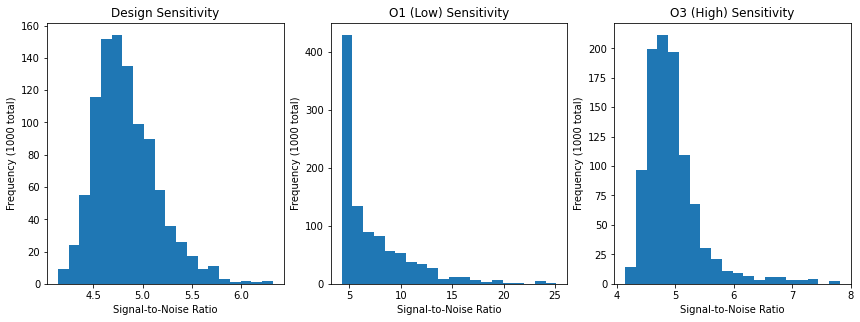

The average SNR for design sensitivity is 4.835620193288221, the standard deviation is 0.3200134933078223, and the skewness is 0.8942099327674431.
The average SNR for low sensitivity is 7.264708112549044, the standard deviation is 3.4440859352006314, and the skewness is 1.8856120283658462.
The average SNR for high sensitivity is 4.950500810319626, the standard deviation is 0.4941020541765346, and the skewness is 2.1888191277031277.


In [52]:
fig = plt.figure()

plt.subplot(1,3,1)
plt.hist(designnoisesnr, bins=20)
plt.ylabel("Frequency (1000 total)")
plt.xlabel("Signal-to-Noise Ratio")
plt.title("Design Sensitivity")

plt.subplot(1,3,2)
plt.hist(lownoisesnr, bins=20)
plt.ylabel("Frequency (1000 total)")
plt.xlabel("Signal-to-Noise Ratio")
plt.title("O1 (Low) Sensitivity")

plt.subplot(1,3,3)
plt.hist(highnoisesnr, bins=20)
plt.ylabel("Frequency (1000 total)")
plt.xlabel("Signal-to-Noise Ratio")
plt.title("O3 (High) Sensitivity")

fig.set_figheight(4.8)
fig.set_figwidth(14.4)

plt.show()


print("The average SNR for design sensitivity is {}, the standard deviation is {}, and the skewness is {}.".format(numpy.mean(designnoisesnr), numpy.std(designnoisesnr), skew(designnoisesnr)))
print("The average SNR for low sensitivity is {}, the standard deviation is {}, and the skewness is {}.".format(numpy.mean(lownoisesnr), numpy.std(lownoisesnr), skew(lownoisesnr)))
print("The average SNR for high sensitivity is {}, the standard deviation is {}, and the skewness is {}.".format(numpy.mean(highnoisesnr), numpy.std(highnoisesnr), skew(highnoisesnr)))